# Lecture 03: PCA applications class demo

![](../img/eva-fun-times.png)

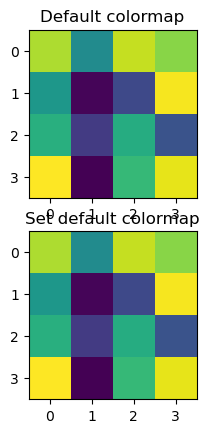

In [1]:
import os
import random
import sys

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (5, 4)
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

## PCA applications

There are tons of applications of PCA. In this section we'll look at a few example applications. 

```{note}
For this demo, we will be working with grayscale images. You can use PCA for coloured images as well. Just that it is a bit more work, as you have to apply it separately for each colour channel. 
```

### PCA for compression

One way to think of PCA is that it's a **data compression** algorithm. Let's work through compressing a random image from the internet using PCA.  

dimensions: (879, 580)


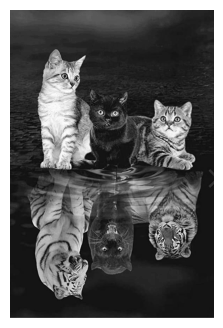

In [2]:
from matplotlib.pyplot import imread, imshow

# source: https://www.amazon.ca/Reflection-Needlework-Cross-Stitch-Embroidery-Decoration/dp/B08CCL7V2T
img = imread(os.path.join('../data/cats_reflection.jpg'))
plt.figure(figsize=[6,4])
plt.axis('off')
image_bw = img.sum(axis=2)/img.sum(axis=2).max()
print('dimensions:', image_bw.shape)
plt.imshow(image_bw, cmap=plt.cm.gray)
plt.show()

Let's apply PCA with 40 components. 

In [3]:
n_components=40
pca=PCA(n_components=n_components)
pca.fit(image_bw)

PCA(n_components=40)

We can examine the components. 

In [4]:
pca.components_.shape

(40, 580)

We can also call SVD on our own and check whether the components of sklearn match with what's returned by SVD. 

In [5]:
image_bw_centered = image_bw - np.mean(image_bw, axis=0) # Let's center the image
U, S, Vt = np.linalg.svd(image_bw_centered, full_matrices=False)
U.shape, S.shape, Vt.shape

((879, 580), (580,), (580, 580))

Do the components given by `sklearn` match with the rows of `Vt`?  

In [6]:
np.allclose(abs(pca.components_[0]), abs(Vt[0])) # taking abs because the solution is unique only upto sign

True

Let's explore the component images created by the first few components: 
$S_0U_0Vt_0 + S_1U_1Vt_1 + \dots + S_{8}U_{8}Vt_{8} + \dots$ 

In [7]:
components = []
k = 10
for i in range(k):
    components.append(U[:, i][:, None]@Vt[i, :][None,:]) 

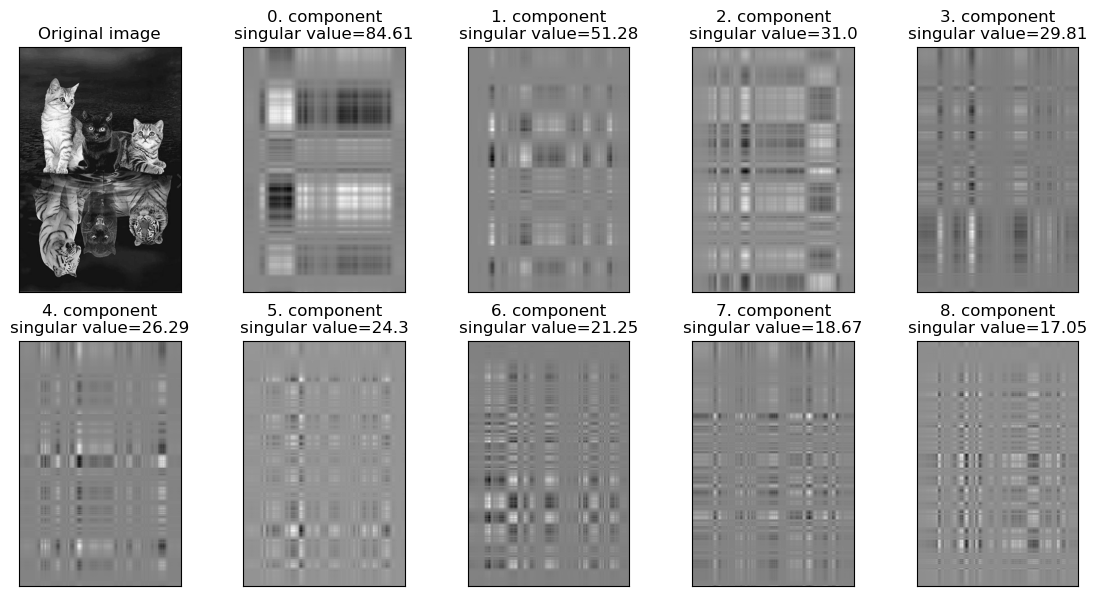

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), subplot_kw={"xticks": (), "yticks": ()})
for i, (component, ax) in enumerate(zip(components, axes.ravel())):
    if i==0:
        ax.imshow(image_bw, cmap=plt.cm.gray)
        ax.set_title('Original image')
    else:
        ax.imshow(component, cmap=plt.cm.gray)
        ax.set_title(f"{i-1}. component\nsingular value={np.round(S[i-1],2)}")
plt.show()

The first component with the largest singular value seems to be capturing the overall brightness and contrast and the subsequent components seem to be capturing more details such as textures and edges. 

How good is the reconstruction with just 40 components? 

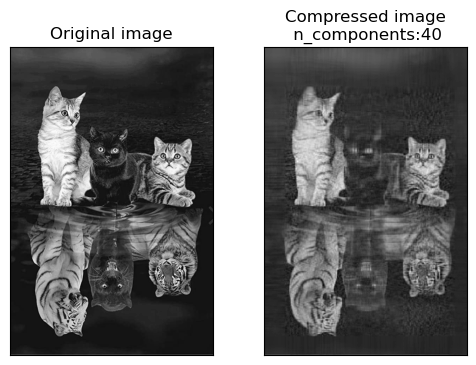

In [9]:
Z_image = pca.transform(image_bw)
W_image = pca.components_
X_hat_image = pca.inverse_transform(Z_image)
plot_orig_compressed(image_bw, X_hat_image, n_components)

Pretty good reconstruction considering that we have only 40 components out of original 580 components.  

Why is this compression?
- The size of the original matrix $X$: ___
- The size of the matrices decomposed matrices $U$, $S$, and $V^T$ after applying SVD: ___
- The size of the matrices $U$, $S$, and $V^T$ after compression: ___

In [10]:
n, d = image_bw.shape[0], image_bw.shape[1]
n, d

(879, 580)

In [11]:
U.shape

(879, 580)

In [12]:
S.shape

(580,)

In [13]:
Vt.shape

(580, 580)

Let's truncate for dimensionality reduction. 

In [14]:
Z_svd = ((U[:, :n_components] * S[:n_components]))

In [15]:
Z_svd.shape

(879, 40)

In [16]:
W_svd = Vt[:n_components,:]

In [17]:
W_svd.shape

(40, 580)

In [18]:
orig_size = (n*d) # How many numbers do you need to store for the original image? 
orig_size

509820

In [19]:
# How many numbers do you need to store for the compressed image?
# n * n_components to store U 
# n_components to store S
# n_components*d to store Vt
compressed_size = (n*n_components) + n_components + (n_components*d) 
compressed_size

58400

<br><br>

### PCA for feature extraction

An important application of PCA is feature extraction. Sometimes instead of using the raw data, it's useful to come up with a more interpretable and compact representation of the data. For instance, in case of images, instead of looking at individual pixels, it’s useful to look at important components.

In Week 1, we clustered human face images, a small subset of [Human Faces dataset](https://www.kaggle.com/datasets/ashwingupta3012/human-faces) (available [here](https://ubcca-my.sharepoint.com/:u:/g/personal/varada_kolhatkar_ubc_ca/EYDqm7QJLfdGh1A0dyqh76kB6PH9ohca-lVrJGATrEh3CQ?e=msqcPM)). We represented each image with feature vector extracted from pretrained CNNs. We got great clustering results but the feature vectors themselves were not very interpretable. Let's examine whether we can do better with interpretation by applying a linear transformation using PCA. 


In [20]:
import random
import os
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms

from torchvision.models import vgg16
import matplotlib.pyplot as plt

In [21]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["image.cmap"] = "gray"

In [22]:
import torchvision

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [25]:
set_seed(seed=42)

In [26]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
            transforms.Lambda(torch.flatten)
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [27]:
image_shape = (IMAGE_SIZE, IMAGE_SIZE)

In [28]:
def plot_sample_bw_imgs(inputs):
    fig, axes = plt.subplots(1, 5, figsize=(10, 8), subplot_kw={"xticks": (), "yticks": ()})
    for image, ax in zip(inputs, axes.ravel()):
        ax.imshow(image.reshape(image_shape))
    plt.show()

In [29]:
data_dir = "../data/people"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
faces_inputs, classes = read_img_dataset(data_dir)

In [30]:
X_faces = faces_inputs.numpy()
X_faces.shape

(367, 40000)

In [31]:
X_faces[:24].shape

(24, 40000)

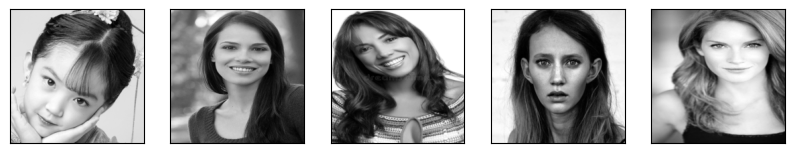

In [32]:
plot_sample_bw_imgs(X_faces[40:])

Let's apply PCA on the data with n_components=100.

We'll look at how to pick n_components in the next lecture.

In [33]:
n_components = 100
pca = PCA(n_components=100, random_state=123)
pca.fit(X_faces)

PCA(n_components=100, random_state=123)

How much variance are we covering with 100 components? 

In [34]:
np.round(pca.explained_variance_ratio_, 3)

array([0.347, 0.098, 0.06 , 0.047, 0.038, 0.027, 0.025, 0.021, 0.019,
       0.015, 0.013, 0.013, 0.012, 0.01 , 0.008, 0.008, 0.007, 0.007,
       0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003,
       0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001], dtype=float32)

This is giving us variance covered by each component. 

In [35]:
pca.explained_variance_ratio_.sum()

0.9410509

In [36]:
Z = pca.transform(X_faces)  # Transform the data
W = pca.components_  # principal components
X_hat = pca.inverse_transform(Z)  # reconstructions

What will be the shape of $Z$, $W$, and $X_{hat}$?

In [37]:
X_faces.shape 

(367, 40000)

In [38]:
Z.shape  

(367, 100)

In [39]:
W.shape

(100, 40000)

In [40]:
X_hat.shape

(367, 40000)

### Components learned by PCA

In [41]:
W

array([[ 7.8977691e-03,  7.9017989e-03,  7.8920592e-03, ...,
         5.6139221e-03,  5.6564738e-03,  5.7036588e-03],
       [-7.3068761e-03, -7.4064992e-03, -7.5246757e-03, ...,
         4.7914064e-03,  4.6576657e-03,  4.5772959e-03],
       [-3.7232949e-04, -3.5709311e-04, -3.7663020e-04, ...,
        -4.2632208e-03, -4.2687790e-03, -4.1943062e-03],
       ...,
       [ 9.8374218e-04, -6.7102344e-05, -7.9967215e-04, ...,
        -2.0153911e-03, -7.3285995e-04, -4.0400025e-04],
       [ 4.9480475e-03,  4.8496895e-03,  4.7600521e-03, ...,
         1.0237189e-03,  1.2844147e-03,  1.5930103e-03],
       [-4.0721067e-04,  2.5537511e-04,  3.2496515e-05, ...,
         1.6387363e-03,  8.4129995e-04,  9.5578353e-04]], dtype=float32)

- We won't quite be able to examine coefficients associated with all features and make sense of them because each feature in the original data just represents a pixel and there are a lot of them. 
- But we can show principal components as images and can look for semantic themes in them. 
- Let's examine the first few components learned by PCA as images.

In [42]:
def plot_components(W): 
    fig, axes = plt.subplots(2, 5, figsize=(10, 4), subplot_kw={"xticks": (), "yticks": ()})
    for i, (component, ax) in enumerate(zip(W, axes.ravel())):
        ax.imshow(component.reshape(image_shape))
        ax.set_title("{}. component".format((i)))
    plt.show()    

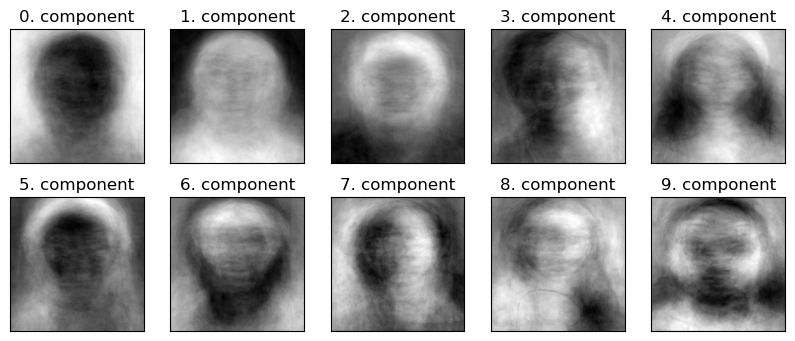

In [43]:
plot_components(W)

- The components encode some semantic aspects of images. 
- It's not always easy to interpret what semantic aspect each component is roughly capturing but we could make some guesses. 
- Component 0 is probably encoding the contrast between the background and the image, in particular, light background and darker face
- Component 1 is probably encoding lighter face and darker background. 

Let's examine some images where these components are strong. 

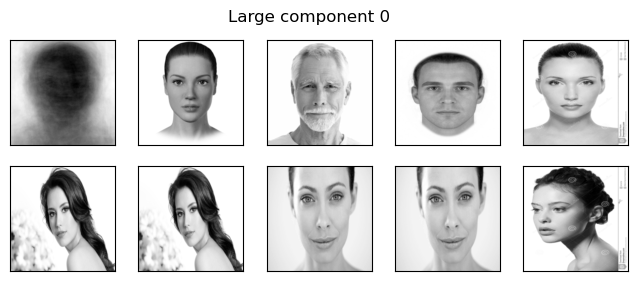

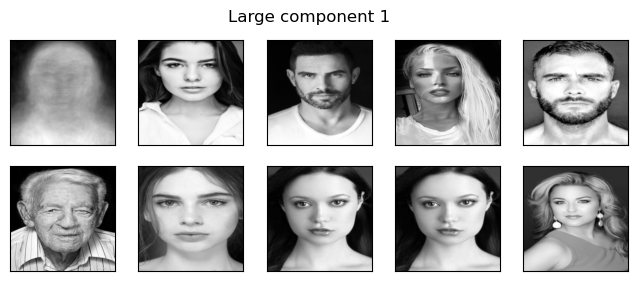

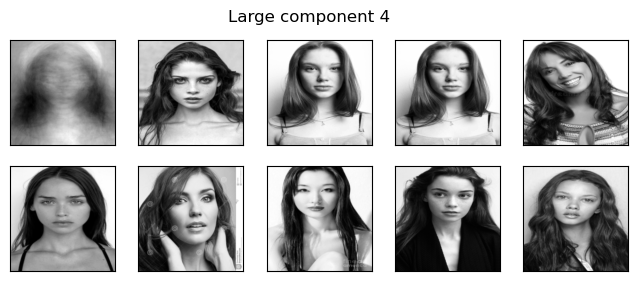

In [44]:
for compn in [0, 1, 4]:
    plot_strong_comp_images(X_faces, Z, W, image_shape, compn=compn)

Looking at the sample images it does seem like: 
- component 0 is capturing lighter background compared foreground 
- component 1 is capturing darker background compared foreground 
- component 4 is hard to interpret. Probably it's capturing hairstyle, in particular, long hair on both sides?

### Original images vs. Reconstructed images 

- We can reconstruct the images from the transformed data $Z$ and components $W$. 
- Let's compare original images with the reconstructed images. 

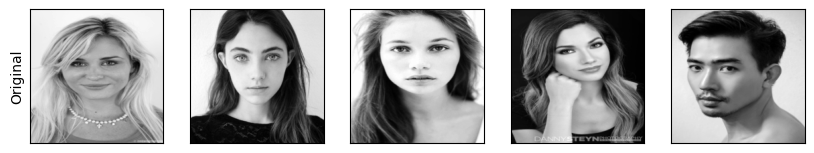

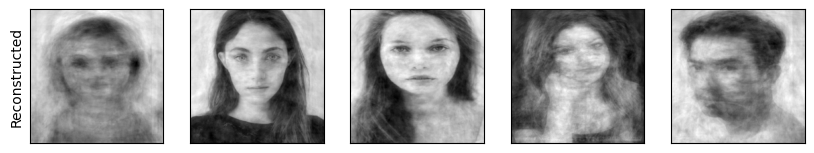

In [45]:
plot_orig_reconstructed_faces(X_faces[10:], X_hat[10:])

Decent reconstruction given that we are using only 100 components!! 

### How many components? 
- We can decide this based on how much variance is covered by how many components
- Or we can look at reconstruction of faces with varying number of components and pick $k$ based on your application. 
- Below we are reconstructing 3 faces with varying number of components in the range 10 to 300. 
- As we can see, with 100 components, we are already capturing recognizable face (compared to 40,000 features in the original image). 

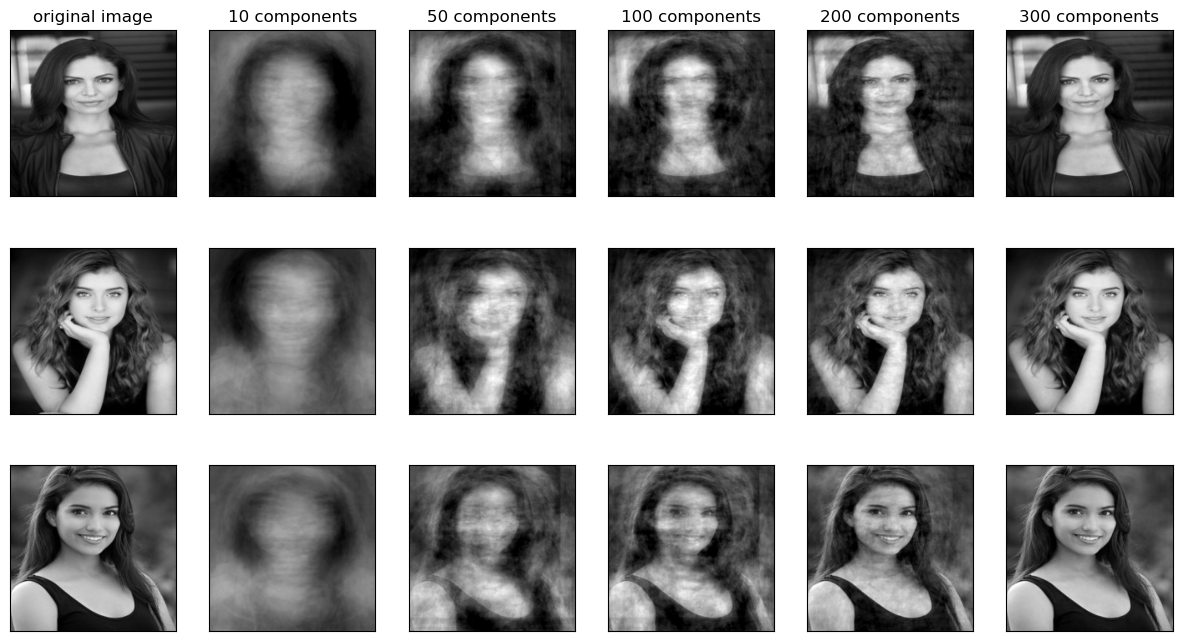

In [46]:
plot_pca_faces(X_faces, image_shape, index=3)

If we fit PCA with `n_components = 200` do you think the first 10 components would change in $W$ compared to when we train it with `n_components=100`?  

In [47]:
pca = PCA(n_components=200)
Z = pca.fit_transform(X_faces)
W = pca.components_

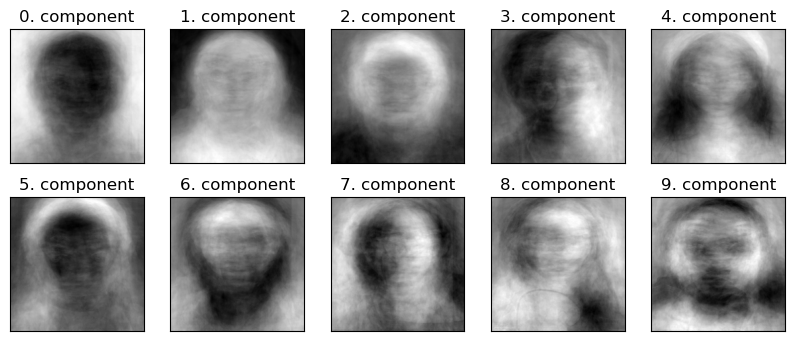

In [48]:
plot_components(W)

<br><br>

### PCA for visualization

- One of the most common applications of PCA is visualizing high dimensional data. 
- Suppose we want to visualize 20-dimensional [countries of the world data](https://www.kaggle.com/fernandol/countries-of-the-world). 
- The dataset has country names linked to population, area size, GDP, literacy percentage, birthrate, mortality, net migration etc.

In [49]:
df = pd.read_csv("../data/countries of the world.csv")
df.head()

Country                               Region  Population  \
0  Afghanistan      ASIA (EX. NEAR EAST)                 31056997     
1  Albania          EASTERN EUROPE                       3581655      
2  Algeria          NORTHERN AFRICA                      32930091     
3  American Samoa   OCEANIA                              57794        
4  Andorra          WESTERN EUROPE                       71201        

   Area (sq. mi.) Pop. Density (per sq. mi.) Coastline (coast/area ratio)  \
0  647500          48,0                       0,00                          
1  28748           124,6                      1,26                          
2  2381740         13,8                       0,04                          
3  199             290,4                      58,29                         
4  468             152,1                      0,00                          

  Net migration Infant mortality (per 1000 births)  GDP ($ per capita)  \
0  23,06         163,07                             700.0                
1  -4,93         21,52                              4500.0               
2  -0,39         31                                 6000.0               
3  -20,71        9,27                               8000.0               
4  6,6           4,05                               19000.0              

  Literacy (%) Phones (per 1000) Arable (%) Crops (%) Other (%) Climate  \
0  36,0         3,2               12,13      0,22      87,65     1        
1  86,5         71,2              21,09      4,42      74,49     3        
2  70,0         78,1              3,22       0,25      96,53     1        
3  97,0         259,5             10         15        75        2        
4  100,0        497,2             2,22       0         97,78     3        

  Birthrate Deathrate Agriculture Industry Service  
0  46,6      20,34     0,38        0,24     0,38    
1  15,11     5,22      0,232       0,188    0,579   
2  17,14     4,61      0,101       0,6      0,298   
3  22,46     3,27      NaN         NaN      NaN     
4  8,71      6,25      NaN         NaN      NaN

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

In [51]:
X_countries = df.drop(columns=["Country", "Region"])

Let's replace commas with periods in columns with type `object`. 

In [52]:
def convert_values(value):
    value = str(value)
    value = value.replace(",", ".")
    return float(value)


for col in X_countries.columns:
    if X_countries[col].dtype == object:
        X_countries[col] = X_countries[col].apply(convert_values)

In [53]:
X_countries.head()

Population  Area (sq. mi.)  Pop. Density (per sq. mi.)  \
0  31056997    647500          48.0                         
1  3581655     28748           124.6                        
2  32930091    2381740         13.8                         
3  57794       199             290.4                        
4  71201       468             152.1                        

   Coastline (coast/area ratio)  Net migration  \
0  0.00                          23.06           
1  1.26                         -4.93            
2  0.04                         -0.39            
3  58.29                        -20.71           
4  0.00                          6.60            

   Infant mortality (per 1000 births)  GDP ($ per capita)  Literacy (%)  \
0  163.07                              700.0               36.0           
1  21.52                               4500.0              86.5           
2  31.00                               6000.0              70.0           
3  9.27                                8000.0              97.0           
4  4.05                                19000.0             100.0          

   Phones (per 1000)  Arable (%)  Crops (%)  Other (%)  Climate  Birthrate  \
0  3.2                12.13       0.22       87.65      1.0      46.60       
1  71.2               21.09       4.42       74.49      3.0      15.11       
2  78.1               3.22        0.25       96.53      1.0      17.14       
3  259.5              10.00       15.00      75.00      2.0      22.46       
4  497.2              2.22        0.00       97.78      3.0      8.71        

   Deathrate  Agriculture  Industry  Service  
0  20.34      0.380        0.240     0.380    
1  5.22       0.232        0.188     0.579    
2  4.61       0.101        0.600     0.298    
3  3.27      NaN          NaN       NaN       
4  6.25      NaN          NaN       NaN


- We have missing values
- The features are in different scales. 
- Let's create a pipeline with `SimpleImputer` and `StandardScaler`. 

In [54]:
from sklearn.impute import SimpleImputer
n_components = 2
pipe = make_pipeline(SimpleImputer(), StandardScaler(), PCA(n_components=n_components))
pipe.fit(X_countries)
X_countries_pca = pipe.transform(X_countries)

In [55]:
print(
    "Variance Explained by the first %d principal components: %0.3f percent"
    % (n_components, sum(pipe.named_steps["pca"].explained_variance_ratio_) * 100)
)

Variance Explained by the first 2 principal components: 43.583 percent


- Good to know! 

For each example, let's get other information from the original data. 

In [56]:
pca_df = pd.DataFrame(X_countries_pca, columns=["Z1", "Z2"], index=X_countries.index)
pca_df["Country"] = df["Country"]
pca_df["Population"] = X_countries["Population"]
pca_df["GDP"] = X_countries["GDP ($ per capita)"]
pca_df["Crops"] = X_countries["Crops (%)"]
pca_df["Infant mortality"] = X_countries["Infant mortality (per 1000 births)"]
pca_df["Birthrate"] = X_countries["Birthrate"]
pca_df["Literacy"] = X_countries["Literacy (%)"]
pca_df["Net migration"] = X_countries["Net migration"]
pca_df.fillna(pca_df["GDP"].mean(), inplace=True)
pca_df.head()

Z1        Z2          Country  Population      GDP  Crops  \
0  5.259255 -2.326683  Afghanistan      31056997    700.0    0.22    
1 -0.260777  1.491964  Albania          3581655     4500.0   4.42    
2  1.154648 -1.904628  Algeria          32930091    6000.0   0.25    
3 -0.448853  2.255437  American Samoa   57794       8000.0   15.00   
4 -2.211518 -1.547689  Andorra          71201       19000.0  0.00    

   Infant mortality  Birthrate  Literacy  Net migration  
0  163.07            46.60      36.0      23.06          
1  21.52             15.11      86.5     -4.93           
2  31.00             17.14      70.0     -0.39           
3  9.27              22.46      97.0     -20.71          
4  4.05              8.71       100.0     6.60

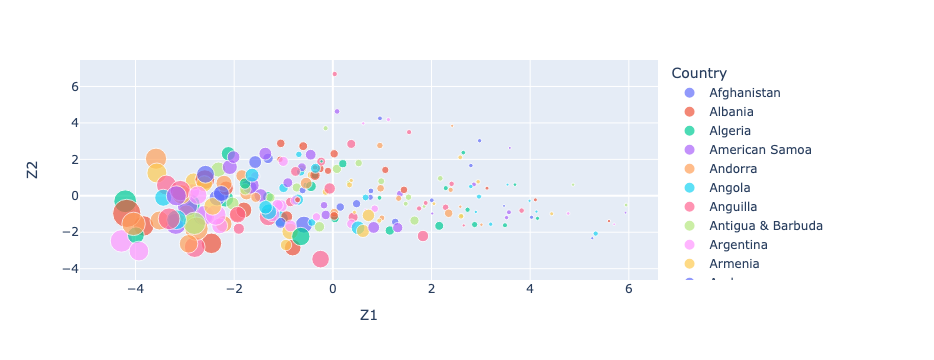

In [57]:
import plotly.express as px

fig = px.scatter(
    pca_df,
    x="Z1",
    y="Z2",
    color="Country",
    size="GDP",
    hover_data=[
        "Population",
        "Infant mortality",
        "Literacy",
        "Birthrate",
        "Net migration",
    ],
)
fig.show()

How to interpret the components? 

- Each principal component has a coefficient associated with each feature in our original dataset. 
- We can interpret the components by looking at the features with relatively bigger values (in magnitude) for coefficients for each components. 

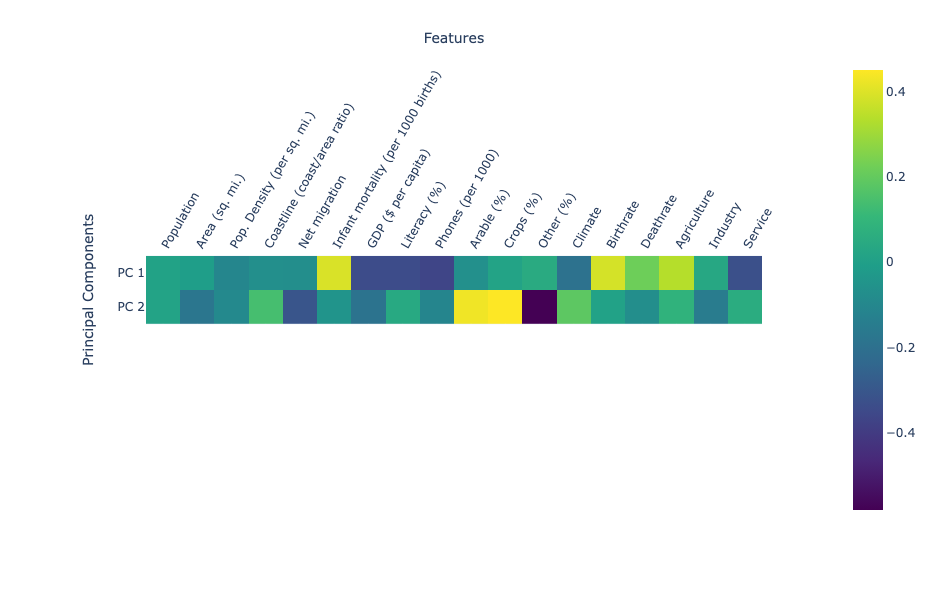

In [58]:
component_labels = ["PC " + str(i + 1) for i in range(n_components)]
W = pipe.named_steps["pca"].components_
plot_pca_w_vectors(W, component_labels, X_countries.columns)

###  Dimensionality reduction to reduce overfitting in supervised setting

- Often you would see dimensionality reduction being used as a preprocessing step in supervised learning setup. 
- More features means higher possibility of overfitting. 
- If we reduce number of dimensions, it may reduce overfitting and  computational complexity. 

### Dimensionality reduction for anomaly detection

- A common application for dimensionality reduction is anomaly or outliers detection. For example:
    - Detecting fraud transactions.  
    - Detecting irregular activity in video frames.  
    - It's hard to find good anomaly detection datasets. A popular one is [The KDD Cup ‘99 dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_kddcup99.html).     
![](../img/pca_anomaly_detection.png)    
<!-- <img src="img/pca_anomaly_detection.png" alt="" height="900" width="900">  -->